# 2D *tobac* Tutorial: GOES-16 ABI Data

This tutorial will demonstrate how to use GOES-16 ABI IR data to detect and track cloud features with *tobac*. Because this tutorial is entirely using 2D spatial data, 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


[]

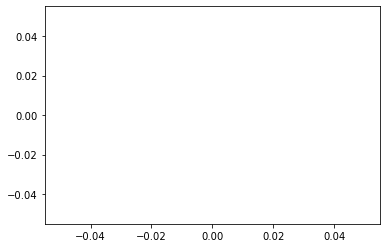

In [2]:
plt.plot()

In [43]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import numpy as np
import goes_conv
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import datetime
import pandas as pd
import cartopy.feature as cfeature
import glob

In [4]:
import sys
sys.path.append("/camp2e/sfreeman/CAMP2Ex_Basin/2019_basin/tobac_dev/tobac-csu/")

import tobac
import imp
imp.reload(tobac)


<module 'tobac' from '/camp2e/sfreeman/CAMP2Ex_Basin/2019_basin/tobac_dev/tobac-csu/tobac/__init__.py'>

In [46]:
sorted(glob.glob('./goes_data_full_21_06_27/*.nc'))

['./goes_data_full_21_06_27/OR_ABI-L2-MCMIPC-M6_G16_s20211781401171_e20211781403549_c20211781404049.nc',
 './goes_data_full_21_06_27/OR_ABI-L2-MCMIPC-M6_G16_s20211781406171_e20211781408549_c20211781409055.nc',
 './goes_data_full_21_06_27/OR_ABI-L2-MCMIPC-M6_G16_s20211781411171_e20211781413544_c20211781414055.nc',
 './goes_data_full_21_06_27/OR_ABI-L2-MCMIPC-M6_G16_s20211781416171_e20211781418555_c20211781419046.nc',
 './goes_data_full_21_06_27/OR_ABI-L2-MCMIPC-M6_G16_s20211781421171_e20211781423544_c20211781424047.nc',
 './goes_data_full_21_06_27/OR_ABI-L2-MCMIPC-M6_G16_s20211781426171_e20211781428544_c20211781429045.nc',
 './goes_data_full_21_06_27/OR_ABI-L2-MCMIPC-M6_G16_s20211781431171_e20211781433544_c20211781434046.nc',
 './goes_data_full_21_06_27/OR_ABI-L2-MCMIPC-M6_G16_s20211781436171_e20211781438555_c20211781439046.nc',
 './goes_data_full_21_06_27/OR_ABI-L2-MCMIPC-M6_G16_s20211781441171_e20211781443549_c20211781444049.nc',
 './goes_data_full_21_06_27/OR_ABI-L2-MCMIPC-M6_G16_s20

In [5]:
in_goes_test = xr.open_dataset('./test_goes_file/OR_ABI-L2-MCMIPC-M6_G16_s20211781401171_e20211781403549_c20211781404049.nc')

In [6]:
in_goes_test

<xarray.Dataset>
Dimensions:                                 (y: 1500, x: 2500, number_of_time_bounds: 2, number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1282 ... 0.04427
  * x                                       (x) float32 -0.1013 ... 0.03861
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds, band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-06-27T14:04:04.9Z
    time_coverage_start:       2021-06-27T14:01:17.1Z
    time_coverage_end:         2021-06-27T14:03:54.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        e5f1e926-22be-4065-aba8-36b2c0a55453

In [7]:
llons, llats  = goes_conv.lat_lon_reproj(in_goes_test)

/camp2e/sfreeman/CAMP2Ex_Basin/2019_basin/tobac_dev/tobac_3D_plots/goes_tobac_example/goes_conv.py:31: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


In [47]:
test_dt = in_goes_test['time_bounds'].mean().values

In [57]:
pd.to_datetime(test_dt).to_pydatetime()

/home/sfreeman/anaconda3/envs/tobac_dev/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: UserWarning: Discarding nonzero nanoseconds in conversion
  exec(code_obj, self.user_global_ns, self.user_ns)


datetime.datetime(2021, 6, 27, 14, 2, 36, 57403)

In [9]:
in_goes_test_for_tobac = xr.Dataset(data_vars=
    {
        "C10": (("time", "Y", "X"), np.expand_dims(in_goes_test['CMI_C10'].values, axis=0)),
    },
    coords=
    {"time": [in_goes_test['time_bounds'].mean().values],
    "lon": (["Y", "X"], llons),
    "lat": (["Y", "X"], llats)},
)

In [10]:
iris_var = in_goes_test_for_tobac['C10'].to_iris()

In [21]:
iris_var

C10 (unknown),time,--,--
Shape,1,1500,2500
Dimension coordinates,,,
time,x,-,-
Auxiliary coordinates,,,
lat,-,x,x
lon,-,x,x


In [37]:
# Keyword arguments for the feature detection step
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=1.5
parameters_features['n_erosion_threshold']=2

parameters_features['min_num']=10
parameters_features['target']='minimum'
parameters_features['threshold']=[230, 220, 210, 200]


In [38]:
# Feature detection and save results to file:
print('starting feature detection')
dxy=2000
Features=tobac.feature_detection_multithreshold(iris_var,dxy,**parameters_features)
#Features.to_hdf(os.path.join(savedir,'Features.h5'),'table')
#print('feature detection performed and saved')


starting feature detection


In [39]:
Features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon
0,0,1,0.859961,2351.036476,27,230,1,2021-06-27 14:02:36,2021-06-27 14:02:36,[51.07442865491197],[-58.02799696573499]
1,0,2,11.548948,2383.003738,391,230,2,2021-06-27 14:02:36,2021-06-27 14:02:36,[50.723448945824124],[-57.13791718531517]
2,0,3,1.459504,2469.359926,37,230,3,2021-06-27 14:02:36,2021-06-27 14:02:36,[51.25065735230365],[-54.017825610391]
3,0,5,7.769386,1406.709740,12,230,4,2021-06-27 14:02:36,2021-06-27 14:02:36,[50.64430639841211],[-87.38189743047329]
4,0,6,16.143667,1524.769058,205,230,5,2021-06-27 14:02:36,2021-06-27 14:02:36,[50.237459154258985],[-83.62320092308335]
...,...,...,...,...,...,...,...,...,...,...,...
523,0,644,1456.875374,1765.249309,16,210,524,2021-06-27 14:02:36,2021-06-27 14:02:36,[15.37761637042772],[-75.83219154443103]
524,0,645,1486.810147,1518.330103,1238,210,525,2021-06-27 14:02:36,2021-06-27 14:02:36,[14.81602626226577],[-80.47132221722855]
525,0,646,1481.156365,474.592396,20,210,526,2021-06-27 14:02:36,2021-06-27 14:02:36,[15.189983462564477],[-101.50979818362266]
526,0,647,1486.630876,2204.749762,4,210,527,2021-06-27 14:02:36,2021-06-27 14:02:36,[14.829600701623757],[-67.55729361704007]


In [40]:
#get cartopy projection for plotting parts of figure
proj = ccrs.PlateCarree()


In [41]:
goes_xformed_pts = proj.transform_points(src_crs = ccrs.PlateCarree(), x=llons, y=llats)
goes_proj_x = goes_xformed_pts[...,0]
goes_proj_y = goes_xformed_pts[...,1]


/home/sfreeman/anaconda3/envs/tobac_dev/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


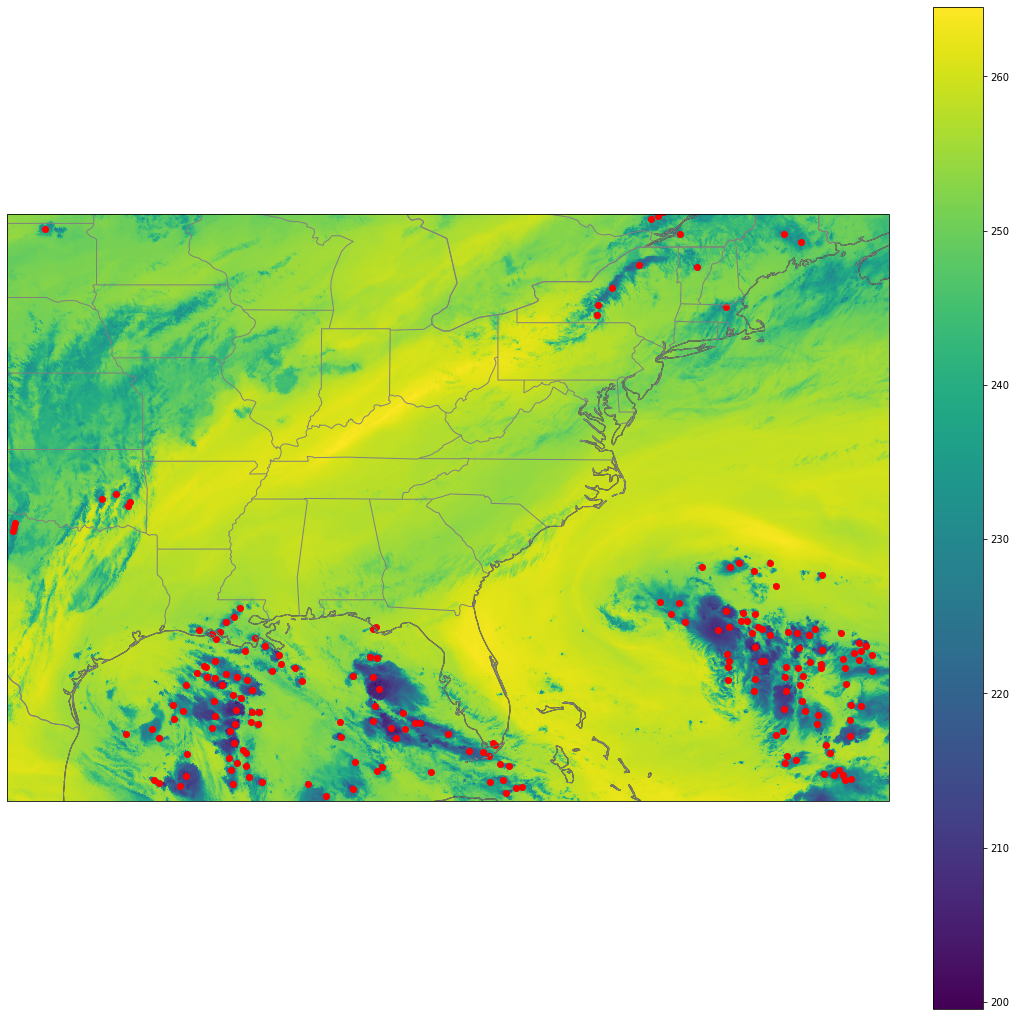

In [42]:
#make the figure
fig1 = plt.figure(figsize = (14,14), constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)

f1_goes_1 = fig1.add_subplot(spec1[0, 0], projection=proj)
#f1_goes_1.gridlines(xlocs=xticks, ylocs=yticks, linestyle=':', zorder=3)
# Label the end-points of the gridlines using the custom tick makers:
#f1_goes_1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
#f1_goes_1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
f1_goes_1.coastlines(resolution='50m')
#f1_goes_1.borders(resolution='50m')
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='50m',
        facecolor='none')

f1_goes_1.add_feature(states_provinces, edgecolor='gray')
f1_goes_1.add_feature(country_borders, edgecolor='gray')

#this works for squares onlu, figure out non-squares.
min_x = 400
min_y = 100
max_x = 2500
max_y = 1100


cmesh = f1_goes_1.pcolormesh(goes_proj_x[min_y:max_y, min_x:max_x].T, goes_proj_y[min_y:max_y, min_x:max_x].T, in_goes_test['CMI_C10'][min_y:max_y, min_x:max_x].T)
plt.colorbar(cmesh)

#f1_goes_1.scatter(goes_proj_x[min_y:max_y, min_x:max_x], goes_proj_y[min_y:max_y, min_x:max_x], )
f1_goes_1.scatter(Features['lon'],Features['lat'], transform=ccrs.PlateCarree(), color='r')
f1_goes_1.set_extent([-100, -65, 23, 45])

In [31]:
fig1 = plt.figure(figsize = (14,14), constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)

f1_goes_1 = fig1.add_subplot(spec1[0, 0], projection=proj)
